In [972]:
import timeit
import logging
from tqdm import tqdm
import arviz as az
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
import pytensor as pyt
from random import randint
from prophet import Prophet
from sklearn.metrics import (
    mean_squared_error,
    root_mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
)
import yfinance
from abc import ABC, abstractmethod

logging.getLogger("prophet").setLevel(logging.WARNING)
logging.getLogger("cmdstanpy").disabled=True

# Fetch data

In [1124]:
data = yfinance.download(
    ["^GSPC", "MSFT", "AAPL", "GOOG"],
    interval="1d",
    start="2005-01-01",
    end="2020-01-01",
)
data

[*********************100%***********************]  4 of 4 completed


Price       Adj Close                                          Close  \
Ticker           AAPL       GOOG        MSFT        ^GSPC       AAPL   
Date                                                                   
2005-01-03   0.953359   5.030750   18.556284  1202.079956   1.130179   
2005-01-04   0.963150   4.826998   18.625687  1188.050049   1.141786   
2005-01-05   0.971586   4.802429   18.584051  1183.739990   1.151786   
2005-01-06   0.972339   4.679335   18.563221  1187.890015   1.152679   
2005-01-07   1.043136   4.810867   18.507717  1186.189941   1.236607   
...               ...        ...         ...          ...        ...   
2019-12-24  68.898689  66.937485  150.531677  3223.379883  71.067497   
2019-12-26  70.265656  67.776466  151.765594  3239.909912  72.477501   
2019-12-27  70.239006  67.352501  152.042938  3240.020020  72.449997   
2019-12-30  70.655876  66.567810  150.732559  3221.290039  72.879997   
2019-12-31  71.172134  66.611656  150.837738  3230.780029  73.412498   

Price                                                High             ...  \
Ticker           GOOG        MSFT        ^GSPC       AAPL       GOOG  ...   
Date                                                                  ...   
2005-01-03   5.048826   26.740000  1202.079956   1.162679   5.071989  ...   
2005-01-04   4.844342   26.840000  1188.050049   1.169107   5.054305  ...   
2005-01-05   4.819685   26.780001  1183.739990   1.165179   4.904118  ...   
2005-01-06   4.696148   26.750000  1187.890015   1.159107   4.879212  ...   
2005-01-07   4.828153   26.670000  1186.189941   1.243393   4.838116  ...   
...               ...         ...          ...        ...        ...  ...   
2019-12-24  67.178001  157.380005  3223.379883  71.222504  67.513000  ...   
2019-12-26  68.019997  158.669998  3239.909912  72.495003  68.066353  ...   
2019-12-27  67.594498  158.960007  3240.020020  73.492500  68.226501  ...   
2019-12-30  66.806999  157.589996  3221.290039  73.172501  67.650002  ...   
2019-12-31  66.850998  157.699997  3230.780029  73.419998  66.900002  ...   

Price              Low                    Open                         \
Ticker            MSFT        ^GSPC       AAPL       GOOG        MSFT   
Date                                                                    
2005-01-03   26.650000  1200.319946   1.156786   4.916571   26.799999   
2005-01-04   26.660000  1185.390015   1.139107   5.016198   26.870001   
2005-01-05   26.760000  1183.719971   1.151071   4.818190   26.840000   
2005-01-06   26.639999  1183.270020   1.154821   4.858788   26.850000   
2005-01-07   26.620001  1182.160034   1.160714   4.748203   26.820000   
...                ...          ...        ...        ...         ...   
2019-12-24  157.119995  3220.510010  71.172501  67.425003  157.479996   
2019-12-26  157.399994  3227.199951  71.205002  67.308502  157.559998   
2019-12-27  158.220001  3234.370117  72.779999  68.149498  159.449997   
2019-12-30  156.729996  3216.570068  72.364998  67.500000  158.990005   
2019-12-31  156.449997  3212.030029  72.482498  66.505501  156.770004   

Price                        Volume                                    
Ticker            ^GSPC        AAPL       GOOG       MSFT       ^GSPC  
Date                                                                   
2005-01-03  1211.920044   691992000  636143518   65002900  1510800000  
2005-01-04  1202.079956  1096810400  552298420  109442100  1721000000  
2005-01-05  1188.050049   680433600  330698912   72463500  1738900000  
2005-01-06  1183.739990   705555200  417041336   76890500  1569100000  
2005-01-07  1187.890015  2227450400  387964757   68723300  1477900000  
...                 ...         ...        ...        ...         ...  
2019-12-24  3225.449951    48478800    6950000    8989200  1296530000  
2019-12-26  3227.199951    93121200   13350000   14520600  2164540000  
2019-12-27  3247.229980   146266000   20768000   18412800  2429150000  
2019-12-30  3240.090088  

In [1125]:
dfs = []
for ticker in ["^GSPC", "MSFT", "GOOG", "AAPL"]:
    df = pd.DataFrame(
        data={
            "open": data["Open"][ticker].to_numpy(),
            "high": data["High"][ticker].to_numpy(),
            "low": data["Low"][ticker].to_numpy(),
            "close": data["Adj Close"][ticker].to_numpy(),
            "typical_price": ((data["Open"][ticker] + data["High"][ticker] + data["Low"][ticker] + data["Close"][ticker]) / 4).to_numpy(),
        }, 
        index=data["Adj Close"][ticker].index
    )
    
    full_date_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='D')
    df = df.reindex(full_date_range).interpolate()
    df["ds"] = df.index
    df.reset_index(drop=True, inplace=True)
    df["series"] = ticker
    dfs.append(df)

# Model

In [1119]:
def get_group_definition(X, pool_cols, pool_type):
    if pool_type == "complete":
        group = np.zeros(len(X), dtype="int")
        group_mapping = {0: "all"}
        n_groups = 1
    else:
        X[pool_cols] = pd.Categorical(X[pool_cols])
        group = X[pool_cols].cat.codes.values
        group_mapping = dict(enumerate(X[pool_cols].cat.categories))
        n_groups = X[pool_cols].nunique()
    return group, n_groups, group_mapping


class TimeSeriesModel:
    def _scale_data(self):
        self.y_min = 0
        self.y_max = self.data["y"].abs().max()
        self.ds_min = self.data["ds"].min()
        self.ds_max = self.data["ds"].max()

        self.data["y"] = self.data["y"] / self.y_max
        self.data["t"] = (self.data["ds"] - self.ds_min) / (self.ds_max - self.ds_min)

    def _process_data(self):
        self.data["ds"] = pd.to_datetime(self.data["ds"])
        self.data.sort_values("ds", inplace=True)
        self._scale_data()

    def _model_init(self):
        i0, i1 = self.data["ds"].idxmin(), self.data["ds"].idxmax()
        T = self.data["t"].iloc[i1] - self.data["t"].iloc[i0]
        slope = (self.data["y"].iloc[i1] - self.data["y"].iloc[i0]) / T
        intercept = self.data["y"].iloc[i0] - slope * self.data["t"].iloc[i0]
        return {
            "slope": slope,
            "intercept": intercept,
            "delta": 0.0,
            "beta": 0.0,
            "sigma": 1.0,
        }

    def fit(
        self,
        data,
        sigma_sd=0.5,
        mcmc_samples=0,
        chains=4,
        cores=4,
        use_prophet_initvals=True,
    ):
        self.mcmc_samples = mcmc_samples

        self.data = data.reset_index(drop=True)
        self._process_data()

        self.initvals = {}
        # if use_prophet_initvals:
        #     self.initvals = self._model_init()

        self.model = pm.Model()
        self.model_idxs = {}
        mu = self.definition(self.model, self.data, self.initvals, self.model_idxs)

        with self.model:
            sigma = pm.HalfNormal(
                "sigma", sigma_sd, initval=self.initvals.get("sigma", 1)
            )
            obs = pm.Normal("obs", mu=mu, sigma=sigma, observed=self.data["y"])

            self.map_approx = None
            self.trace = None
            if self.mcmc_samples == 0:
                self.map_approx = pm.find_MAP(progressbar=True, maxeval=1e4)
            else:
                self.trace = pm.sample(self.mcmc_samples, chains=chains, cores=cores)

    def _make_future_df(self, days):
        future = pd.DataFrame(
            {
                "ds": pd.DatetimeIndex(
                    np.hstack(
                        (
                            self.data["ds"].unique().to_numpy(), 
                            pd.date_range(
                                self.ds_max,
                                self.ds_max + pd.Timedelta(days, "D"),
                                inclusive="right",
                            ).to_numpy()
                        )
                    )
                )
            }
        )
        future["t"] = (future["ds"] - self.ds_min) / (self.ds_max - self.ds_min)
        return future

    def predict(self, days):
        future = self._make_future_df(days)
        forecasts = self._predict(future, self.mcmc_samples, self.map_approx, self.trace)
        
        for group_code in range(forecasts.shape[0]):
            future[f"yhat_{group_code}"] = forecasts[group_code] * self.y_max
            for model_type, model_cnt in self.model_idxs.items():
                if model_type.startswith("fs"):
                    continue
                for model_idx in range(model_cnt):
                    future[f"{model_type}_{model_idx}_{group_code}"] *= self.y_max

        return future

    def _predict(self, future, mcmc_samples, map_approx, trace):
        if mcmc_samples == 0:
            return self._predict_map(future, map_approx)

        return self._predict_mcmc(future, trace)

    def plot(self, future, y_true=None, pool_cols=None):
        plt.figure(figsize=(14, 100 * 6))
        plt.subplot(100, 1, 1)
        plt.title("Predictions")
        plt.grid()
        
        group, n_groups, groups_ = get_group_definition(self.data, pool_cols, "partial")
        for group_code, group_name in groups_.items():
            group_idx = (group == group_code)
            color = np.random.rand(3)
            plt.scatter(
                self.data["ds"][group_idx], self.data["y"][group_idx] * self.y_max, s=0.5, color=color, label=group_name
            )
            
        if y_true is not None:
            test_group, test_n_groups, test_groups_ = get_group_definition(y_true, pool_cols, "partial")
            for group_code, group_name in test_groups_.items():
                group_idx = (test_group == group_code)
                color = np.random.rand(3)
                plt.scatter(y_true["ds"][group_idx], y_true["y"][group_idx], s=0.5, color=color, label=f"y - {group_name}")

        for group_code, group_name in groups_.items():
            plt.plot(future["ds"], future[f"yhat_{group_code}"], lw=1, label=f"yhat - {group_name}")

        plt.legend()
        plot_params = {"idx": 1}
        self._plot(plot_params, future, self.data, self.y_max, y_true)

    def metrics(self, y_true, future, pool_cols=None):
        metrics = {}
        test_group, test_n_groups, test_groups_ = get_group_definition(y_true, pool_cols, "partial")
        for group_code, group_name in test_groups_.items():
            metrics[group_name] = {}
            group_idx = (test_group == group_code)
            y = y_true["y"][group_idx]
            yhat = future[f"yhat_{group_code}"][-len(y):]
            metrics[group_name]["mse"] = mean_squared_error(y, yhat)
            metrics[group_name]["rmse"] = root_mean_squared_error(y, yhat)
            metrics[group_name]["mae"] = mean_absolute_error(y, yhat)
            metrics[group_name]["mape"] = mean_absolute_percentage_error(y, yhat)

        return pd.DataFrame(metrics)

    def __add__(self, other):
        return AdditiveTimeSeries(self, other)

    def __mul__(self, other):
        return MultiplicativeTimeSeries(self, other)


class AdditiveTimeSeries(TimeSeriesModel):
    def __init__(self, left, right):
        self.left = left
        self.right = right

    def definition(self, *args, **kwargs):
        return self.left.definition(*args, **kwargs) + self.right.definition(
            *args, **kwargs
        )

    def _predict(self, *args, **kwargs):
        return self.left._predict(*args, **kwargs) + self.right._predict(
            *args, **kwargs
        )

    def _plot(self, *args, **kwargs):
        self.left._plot(*args, **kwargs)
        self.right._plot(*args, **kwargs)


class MultiplicativeTimeSeries(TimeSeriesModel):
    def __init__(self, left, right):
        self.left = left
        self.right = right

    def definition(self, *args, **kwargs):
        return self.left.definition(*args, **kwargs) * (
            1 + self.right.definition(*args, **kwargs)
        )

    def _predict(self, *args, **kwargs):
        return self.left._predict(*args, **kwargs) * (
            1 + self.right._predict(*args, **kwargs)
        )

    def _plot(self, *args, **kwargs):
        self.left._plot(*args, **kwargs)
        self.right._plot(*args, **kwargs)


class LinearTrend(TimeSeriesModel):
    def __init__(
        self,
        n_changepoints=25,
        changepoint_range=0.8,
        slope_mean=0,
        slope_sd=5,
        intercept_mean=0,
        intercept_sd=5,
        delta_mean=0,
        delta_sd=0.05,
        pool_cols=None,
        pool_type="complete",
    ):
        self.n_changepoints = n_changepoints
        self.changepoint_range = changepoint_range
        self.slope_mean = slope_mean
        self.slope_sd = slope_sd
        self.intercept_mean = intercept_mean
        self.intercept_sd = intercept_sd
        self.delta_mean = delta_mean
        self.delta_sd = delta_sd

        self.pool_cols = pool_cols
        self.pool_type = pool_type

    def definition(self, model, data, initvals, model_idxs):
        model_idxs["lt"] = model_idxs.get("lt", 0)
        self.model_idx = model_idxs["lt"]
        model_idxs["lt"] += 1

        group, n_groups, self.groups_ = get_group_definition(
            data, self.pool_cols, self.pool_type
        )

        t = np.array(data["t"])
        hist_size = int(np.floor(data.shape[0] * self.changepoint_range))
        cp_indexes = (
            np.linspace(0, hist_size - 1, self.n_changepoints + 1).round().astype(int)
        )
        self.s = np.array(data.iloc[cp_indexes]["t"].tail(-1))

        # * 1 casts the boolean to integers
        A = (t[:, None] > self.s) * 1

        with model:
            slope = pm.Normal(
                f"lt_{self.model_idx} - slope",
                self.slope_mean,
                self.slope_sd,
                initval=initvals.get("slope", None),
                shape=n_groups,
            )

            delta_sd = self.delta_sd
            if self.delta_sd is None:
                delta_sd = pm.Exponential(f"lt_{self.model_idx} - tau", 1.5)

            delta = pm.Laplace(
                f"lt_{self.model_idx} - delta",
                self.delta_mean,
                delta_sd,
                shape=(n_groups, self.n_changepoints),
            )

            intercept = pm.Normal(
                f"lt_{self.model_idx} - intercept",
                self.intercept_mean,
                self.intercept_sd,
                initval=initvals.get("intercept", None),
                shape=n_groups,
            )

            gamma = -self.s * delta[group, :]

            trend = pm.Deterministic(
                f"lt_{self.model_idx} - trend",
                (slope[group] + pm.math.sum(A * delta[group], axis=1)) * t
                + (intercept[group] + pm.math.sum(A * gamma, axis=1)),
            )

        return trend

    def _predict_map(self, future, map_approx):
        forecasts = []
        new_A = (np.array(future["t"])[:, None] > self.s) * 1

        for group_code in self.groups_.keys():
            forecasts.append(
                np.array(
                    (
                        map_approx[f"lt_{self.model_idx} - slope"][group_code]
                        + np.dot(
                            new_A,
                            map_approx[f"lt_{self.model_idx} - delta"][group_code],
                        )
                    )
                    * future["t"]
                    + (
                        map_approx[f"lt_{self.model_idx} - intercept"][group_code]
                        + np.dot(
                            new_A,
                            (
                                -self.s
                                * map_approx[f"lt_{self.model_idx} - delta"][group_code]
                            ),
                        )
                    )
                )
            )
            future[f"lt_{self.model_idx}_{group_code}"] = forecasts[-1]

        return np.vstack(forecasts)

    def _predict_mcmc(self, future, trace):
        forecasts = []
        new_A = (np.array(future["t"])[:, None] > self.s) * 1

        for group_code in self.groups_.keys():
            delta = (
                trace["posterior"][f"lt_{self.model_idx} - delta"]
                .to_numpy()[:, :, group_code]
                .mean(0)
            )
            slope = (
                trace["posterior"][f"lt_{self.model_idx} - slope"]
                .to_numpy()[:, :, group_code]
                .mean(0)
            )
            intercept = (
                trace["posterior"][f"lt_{self.model_idx} - intercept"]
                .to_numpy()[:, :, group_code]
                .mean(0)
            )

            forecasts.append(
                (
                    (slope + np.dot(new_A, delta.T)).T * future["t"].to_numpy()
                    + (intercept + np.dot(new_A, (-self.s * delta).T)).T
                ).mean(0)
            )
            future[f"lt_{self.model_idx}_{group_code}"] = forecasts[-1]

        return np.vstack(forecasts)

    def _plot(self, plot_params, future, data, y_max, y_true=None):
        plot_params["idx"] += 1
        plt.subplot(100, 1, plot_params["idx"])
        plt.title(f"lt_{self.model_idx}")
        plt.grid()

        for group_code, group_name in self.groups_.items():
            plt.plot(future["ds"], future[f"lt_{self.model_idx}_{group_code}"], lw=1, label=group_name)

        plt.legend()


class FourierSeasonality(TimeSeriesModel):
    def __init__(
        self,
        period,
        series_order,
        beta_mean=0,
        beta_sd=10,
        pool_cols=None,
        pool_type="complete",
    ):
        self.period = period
        self.series_order = series_order
        self.beta_mean = beta_mean
        self.beta_sd = beta_sd

        self.pool_cols = pool_cols
        self.pool_type = pool_type

    def _fourier_series(self, data):
        # convert to days since epoch
        NANOSECONDS_TO_SECONDS = 1000 * 1000 * 1000
        t = (
            data["ds"].to_numpy(dtype=np.int64)
            // NANOSECONDS_TO_SECONDS
            / (3600 * 24.0)
        )

        x_T = t * np.pi * 2
        fourier_components = np.empty((data["ds"].shape[0], 2 * self.series_order))
        for i in range(self.series_order):
            c = x_T * (i + 1) / self.period
            fourier_components[:, 2 * i] = np.sin(c)
            fourier_components[:, (2 * i) + 1] = np.cos(c)

        return fourier_components

    def definition(self, model, data, initvals, model_idxs):
        model_idxs["fs"] = model_idxs.get("fs", 0)
        self.model_idx = model_idxs["fs"]
        model_idxs["fs"] += 1

        group, n_groups, self.groups_ = get_group_definition(
            data, self.pool_cols, self.pool_type
        )

        x = self._fourier_series(data)
        beta_initval = initvals.get("beta", None)
        if beta_initval is not None:
            beta_initval = np.array([beta_initval] * 2 * self.series_order)

        with model:
            beta = pm.Normal(
                f"fs_{self.model_idx} - beta(p={self.period},n={self.series_order})",
                mu=self.beta_mean,
                sigma=self.beta_sd,
                shape=(n_groups, 2 * self.series_order),
                initval=beta_initval,
            )
        return pm.math.sum(x * beta[group], axis=1)

    def _det_seasonality_posterior(self, beta, x):
        return np.dot(x, beta.T)

    def _predict_map(self, future, map_approx):
        forecasts = []
        for group_code in self.groups_.keys():
            forecasts.append(
                self._det_seasonality_posterior(
                    map_approx[
                        f"fs_{self.model_idx} - beta(p={self.period},n={self.series_order})"
                    ][group_code],
                    self._fourier_series(future),
                )
            )
            future[f"fs_{self.model_idx}_{group_code}"] = forecasts[-1]

        return np.vstack(forecasts)

    def _predict_mcmc(self, future, trace):
        forecasts = []
        for group_code in self.groups_.keys():
            forecasts.append(
                self._det_seasonality_posterior(
                    trace["posterior"][
                        f"fs_{self.model_idx} - beta(p={self.period},n={self.series_order})"
                    ]
                    .to_numpy()[:, :, group_code]
                    .mean(0),
                    self._fourier_series(future),
                ).T.mean(0)
            )
            future[f"fs_{self.model_idx}_{group_code}"] = forecasts[-1]

        return np.vstack(forecasts)

    def _plot(self, plot_params, future, data, y_max, y_true=None):
        date = future["ds"] if self.period > 7 else future["ds"].dt.day_name()
        plot_params["idx"] += 1
        plt.subplot(100, 1, plot_params["idx"])
        plt.title(f"fs_{self.model_idx} - p={self.period},n={self.series_order}")
        plt.grid()
        
        for group_code, group_name in self.groups_.items():
            plt.plot(
                date[-int(self.period):],
                future[f"fs_{self.model_idx}_{group_code}"][-int(self.period):],
                lw=1,
                label=group_name,
            )
            
        plt.legend()

# Experiments

In [1126]:
def generate_train_test_df(start, window, horizon, dfs, for_prophet=False):
    train_dfs = []
    test_dfs = []
    scales = []
    for df in dfs:
        train_df = df[start:start + window].copy()
        scales.append(train_df["typical_price"].max())
        train_df["y"] = train_df["typical_price"] / scales[-1]
        test_df = df[start + window:start + window + horizon].copy()
        test_df["y"] = test_df["typical_price"] / scales[-1]
        train_dfs.append(train_df)
        test_dfs.append(test_df)

    if for_prophet:
        return train_dfs, test_dfs, scales

    return pd.concat(train_dfs), pd.concat(test_dfs), scales

In [1132]:
train_df, test_df, scales = generate_train_test_df(start=0, window=365 * 5, horizon=365, dfs=dfs)     
train_df

,open,high,low,close,typical_price,ds,series,y
0,1211.920044,1217.800049,1200.319946,1202.079956,1208.029999,2005-01-03,^GSPC,0.773346
1,1202.079956,1205.839966,1185.390015,1188.050049,1195.339996,2005-01-04,^GSPC,0.765222
2,1188.050049,1192.729980,1183.719971,1183.739990,1187.059998,2005-01-05,^GSPC,0.759921
3,1183.739990,1191.630005,1183.270020,1187.890015,1186.632507,2005-01-06,^GSPC,0.759648
4,1187.890015,1192.199951,1182.160034,1186.189941,1187.109985,2005-01-07,^GSPC,0.759953
...,...,...,...,...,...,...,...,...
1820,7.561429,7.641071,7.486071,6.375109,7.561518,2009-12-28,AAPL,0.997036
1821,7.593929,7.597143,7.454643,6.299491,7.528393,2009-12-29,AAPL,0.992668
1822,7.458214,7.571429,7.439643,6.376012,7.506964,2009-12-30,AAPL,0.989843
1823,7.611786,7.619643,7.520000,6.348597,7.569375,2009-12-31,AAPL,0.998072


In [1133]:
test_df

,open,high,low,close,typical_price,ds,series,y
1825,1121.580017,1130.755005,1115.685059,1124.044983,1123.016266,2010-01-02,^GSPC,0.718923
1826,1119.070038,1132.312500,1116.122559,1128.517487,1124.005646,2010-01-03,^GSPC,0.719556
1827,1116.560059,1133.869995,1116.560059,1132.989990,1124.995026,2010-01-04,^GSPC,0.720189
1828,1132.660034,1136.630005,1129.660034,1136.520020,1133.867523,2010-01-05,^GSPC,0.725869
1829,1135.709961,1139.189941,1133.949951,1137.140015,1136.497467,2010-01-06,^GSPC,0.727553
...,...,...,...,...,...,...,...,...
2185,11.639643,11.666429,11.609286,9.805334,11.634822,2010-12-28,AAPL,1.534128
2186,11.650714,11.658929,11.610714,9.799911,11.634464,2010-12-29,AAPL,1.534081
2187,11.624286,11.625357,11.537500,9.750806,11.586607,2010-12-30,AAPL,1.527771
2188,11.533929,11.552857,11.475357,9.717665,11.520536,2010-12-31,AAPL,1.519059


In [ ]:
lt = LinearTrend(pool_cols="series", pool_type="partial", n_changepoints=25)
ft1 = FourierSeasonality(365.25, 10, pool_cols="series", pool_type="partial")
ft2 = FourierSeasonality(91.3125, 7, pool_cols="series", pool_type="partial")
ft3 = FourierSeasonality(30.4375, 5, pool_cols="series", pool_type="partial")
ft4 = FourierSeasonality(7, 3, pool_cols="series", pool_type="partial")
model = lt * (ft1 + ft2 + ft3 + ft4)
model.fit(train_df, use_prophet_initvals=False, mcmc_samples=1000)
yhat = model.predict(horizon)
model.metrics(test_df, yhat, pool_cols="series")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lt_0 - slope, lt_0 - delta, lt_0 - intercept, fs_0 - beta(p=365.25,n=10), fs_1 - beta(p=91.3125,n=7), fs_2 - beta(p=30.4375,n=5), fs_3 - beta(p=7,n=3), sigma]


Output()

In [ ]:
pm.model_to_graphviz(model.model)

In [ ]:
pm.plot_trace(model.trace)

In [1122]:
yhat

,ds,t,lt_0_0,lt_0_1,lt_0_2,lt_0_3,fs_0_0,fs_0_1,fs_0_2,fs_0_3,fs_1_0,fs_1_1,fs_1_2,fs_1_3,yhat_0,yhat_1,yhat_2,yhat_3
0,2005-01-03,0.000000,0.190680,0.226968,0.689727,0.773248,0.077065,0.109875,0.068963,0.016419,-0.001179,-0.001190,-0.000701,-0.000125,0.205149,0.251636,0.736810,0.785848
1,2005-01-04,0.000548,0.190893,0.227754,0.689803,0.773235,0.074695,0.111905,0.067932,0.014967,-0.000560,-0.001179,-0.000649,-0.000199,0.205045,0.252972,0.736216,0.784654
2,2005-01-05,0.001096,0.191107,0.228539,0.689879,0.773221,0.071586,0.113576,0.066878,0.013441,0.000979,0.000404,0.000300,0.000286,0.204975,0.254588,0.736224,0.783835
3,2005-01-06,0.001645,0.191321,0.229324,0.689955,0.773208,0.067688,0.114810,0.065803,0.011846,0.001353,0.000410,0.000703,0.000131,0.204529,0.255747,0.735842,0.782469
4,2005-01-07,0.002193,0.191534,0.230109,0.690031,0.773194,0.062962,0.115533,0.064710,0.010186,0.000243,0.001329,0.000464,-0.000010,0.203640,0.257000,0.735003,0.781062
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2185,2010-12-28,1.197917,1.408650,1.151851,1.109062,0.896275,0.079464,0.093824,0.074497,0.024003,-0.000560,-0.001179,-0.000649,-0.000199,1.519799,1.258564,1.190964,0.917610
2186,2010-12-29,1.198465,1.409998,1.152885,1.109964,0.896809,0.080069,0.096125,0.073846,0.023049,0.000979,0.000404,0.000300,0.000286,1.524275,1.264171,1.192264,0.917736
2187,2010-12-30,1.199013,1.411346,1.153918,1.110867,0.897342,0.080448,0.098602,0.073103,0.022018,0.001353,0.000410,0.000703,0.000131,1.526796,1.268170,1.192855,0.917217
2188,2010-12-31,1.199561,1.412694,1.154952,1.111770,0.897876,0.080517,0.101183,0.072280,0.020908,0.000243,0.001329,0.000464,-0.000010,1.526783,1.273348,1.192644,0.916639


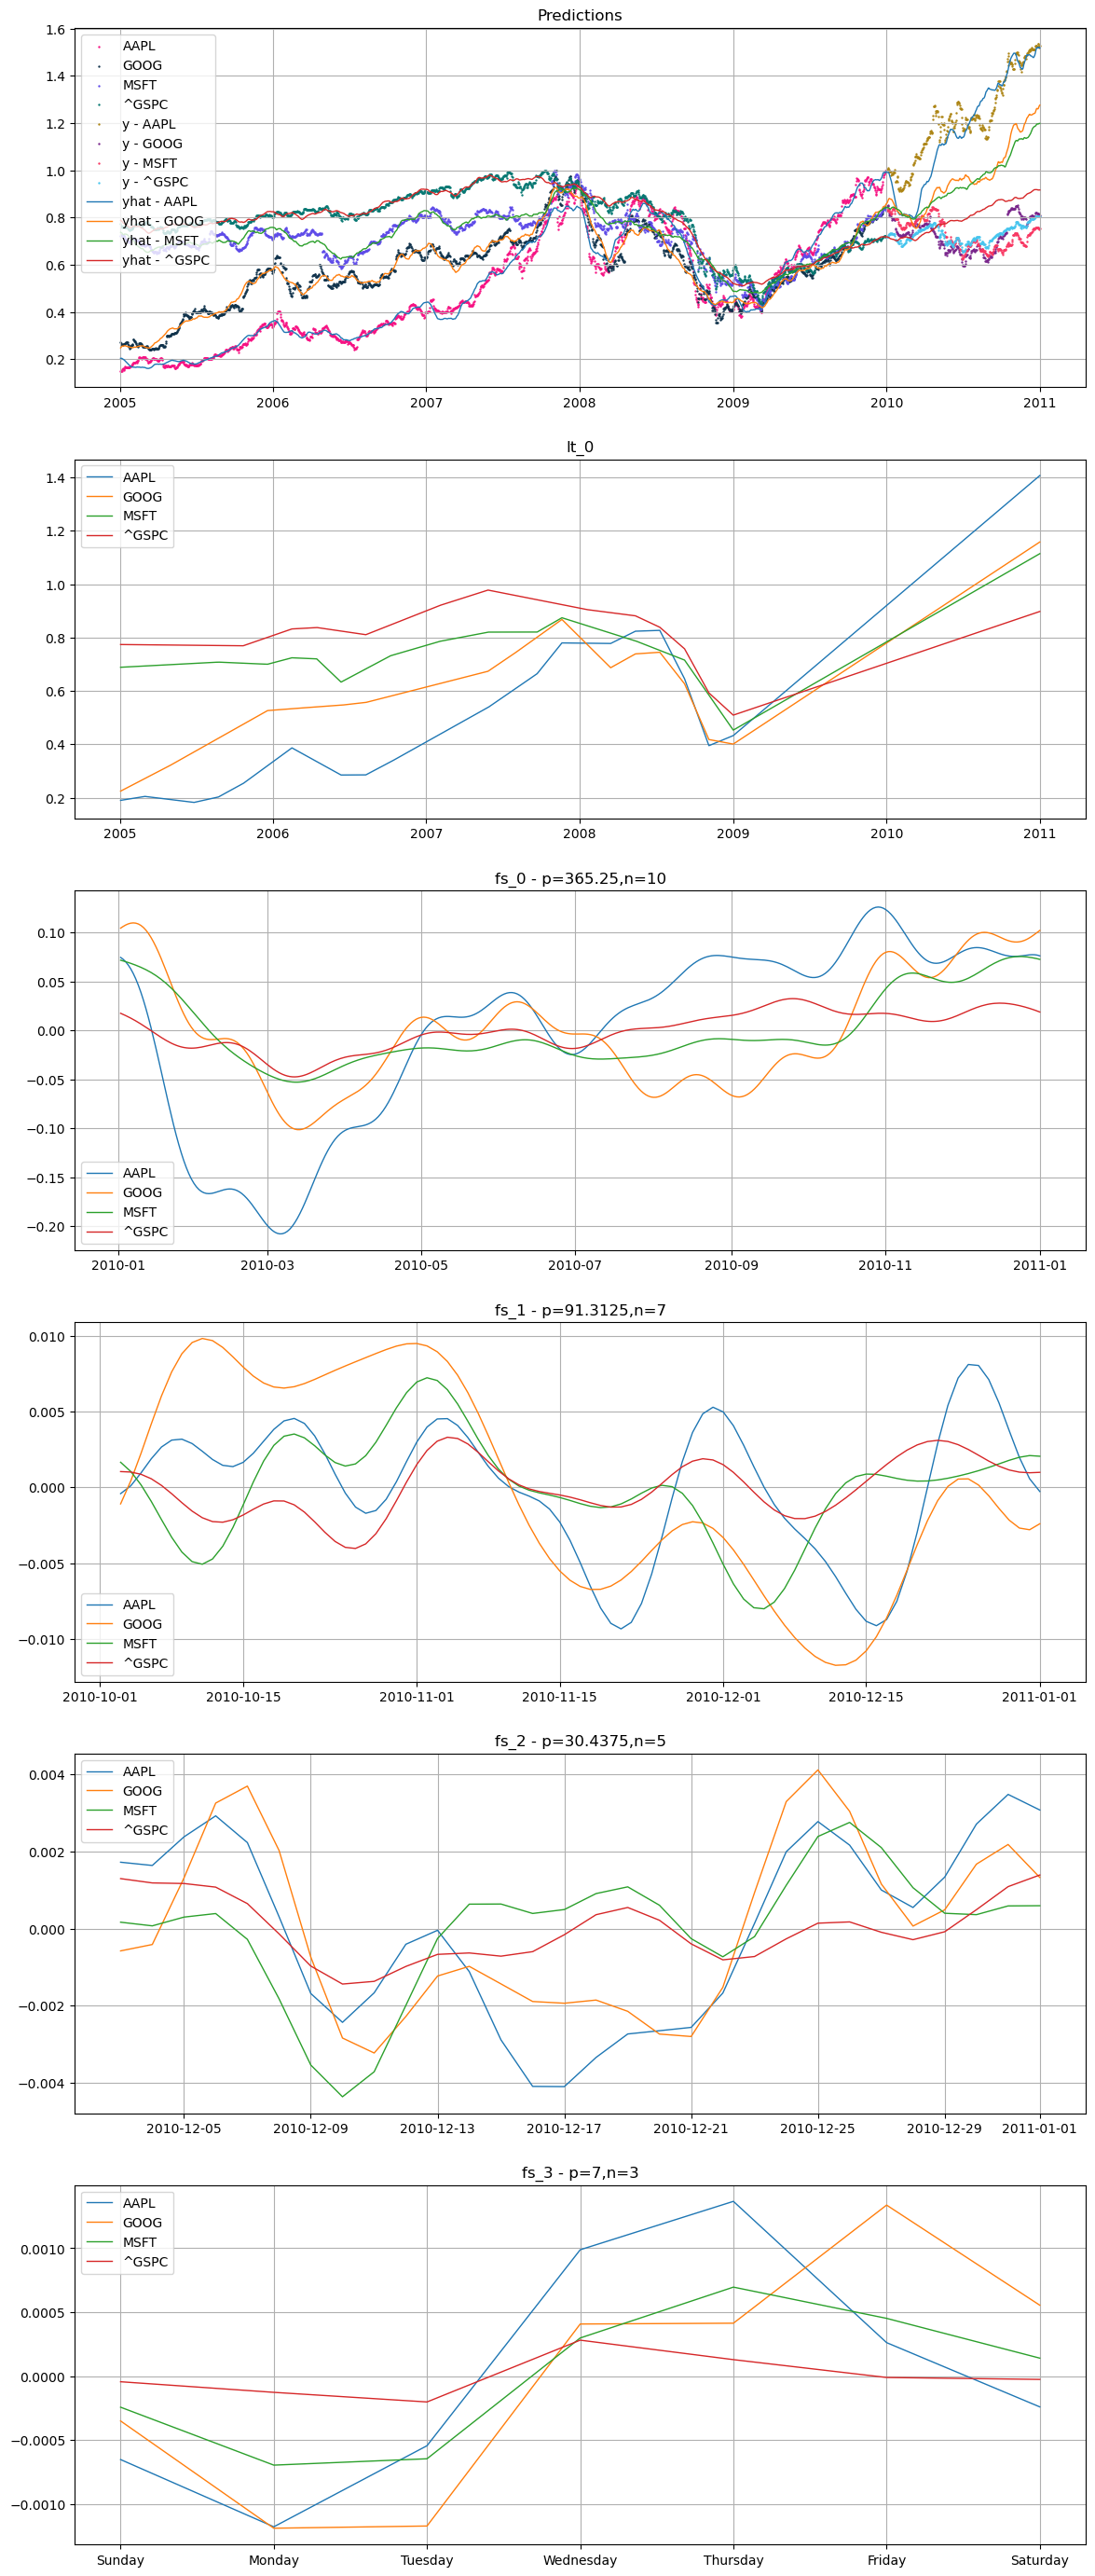

In [1147]:
model.plot(yhat, y_true=test_df, pool_cols="series")

In [1134]:
train_df_prophet, test_df_prophet, scales_prophet = generate_train_test_df(start=0, window=365 * 5, horizon=365, dfs=dfs, for_prophet=True)     
train_df_prophet[0]

,open,high,low,close,typical_price,ds,series,y
0,1211.920044,1217.800049,1200.319946,1202.079956,1208.029999,2005-01-03,^GSPC,0.773346
1,1202.079956,1205.839966,1185.390015,1188.050049,1195.339996,2005-01-04,^GSPC,0.765222
2,1188.050049,1192.729980,1183.719971,1183.739990,1187.059998,2005-01-05,^GSPC,0.759921
3,1183.739990,1191.630005,1183.270020,1187.890015,1186.632507,2005-01-06,^GSPC,0.759648
4,1187.890015,1192.199951,1182.160034,1186.189941,1187.109985,2005-01-07,^GSPC,0.759953
...,...,...,...,...,...,...,...,...
1820,1127.530029,1130.380005,1123.510010,1127.780029,1127.300018,2009-12-28,^GSPC,0.721665
1821,1128.550049,1130.380005,1126.079956,1126.199951,1127.802490,2009-12-29,^GSPC,0.721987
1822,1125.530029,1126.420044,1121.939941,1126.420044,1125.077515,2009-12-30,^GSPC,0.720242
1823,1126.599976,1127.640015,1114.810059,1115.099976,1121.037506,2009-12-31,^GSPC,0.717656


In [1135]:
test_df_prophet[0]

,open,high,low,close,typical_price,ds,series,y
1825,1121.580017,1130.755005,1115.685059,1124.044983,1123.016266,2010-01-02,^GSPC,0.718923
1826,1119.070038,1132.312500,1116.122559,1128.517487,1124.005646,2010-01-03,^GSPC,0.719556
1827,1116.560059,1133.869995,1116.560059,1132.989990,1124.995026,2010-01-04,^GSPC,0.720189
1828,1132.660034,1136.630005,1129.660034,1136.520020,1133.867523,2010-01-05,^GSPC,0.725869
1829,1135.709961,1139.189941,1133.949951,1137.140015,1136.497467,2010-01-06,^GSPC,0.727553
...,...,...,...,...,...,...,...,...
2185,1259.099976,1259.900024,1256.219971,1258.510010,1258.432495,2010-12-28,^GSPC,0.805612
2186,1258.780029,1262.599976,1258.780029,1259.780029,1259.985016,2010-12-29,^GSPC,0.806606
2187,1259.439941,1261.089966,1256.319946,1257.880005,1258.682465,2010-12-30,^GSPC,0.805772
2188,1256.760010,1259.339966,1254.189941,1257.640015,1256.982483,2010-12-31,^GSPC,0.804684


In [1143]:
for df, df_test in zip(train_df_prophet, test_df_prophet):
    prophet = Prophet(yearly_seasonality=True, weekly_seasonality=True, seasonality_mode="multiplicative")
    prophet.fit(df)
    future = prophet.make_future_dataframe(periods=365, include_history=True)
    forecast = prophet.predict(future)
    print(f"{df["series"].iloc[0]}-mape: {mean_absolute_percentage_error(df_test["y"], forecast[-365:]["yhat"])}")

^GSPC-mape: 0.10525174874173121
MSFT-mape: 0.31315162919357203
GOOG-mape: 0.3349126615209467
AAPL-mape: 0.07725510021551356
